In [1]:
import numpy as np
import pandas as pd
from fasttext import FastText

In [2]:
import seaborn as sns
from scipy.spatial import ConvexHull

In [3]:
ft_ru = FastText.load_model('cc.ru.300.bin')

In [4]:
import json
import io
import os

with io.open(os.path.join(os.getcwd(), 'data', 'habr-top-ru.json'), encoding='utf-8') as fp:
    data_ru = json.load(fp)

In [5]:
len(data_ru)

1000

In [6]:
data_ru[0].keys()

dict_keys(['title', 'preview', 'article', 'tags', 'link'])

In [7]:
df_v = pd.DataFrame(data_ru)

In [8]:
df_v.head()

,title,preview,article,tags,link
0,Как это сделано: Оптика для EUV/BEUV литографии,"Все чаще в обсудениях, посвященных внедрению в...",Прохождение излучения в EUV степпере Часто в о...,"[Производство и разработка электроники *, На...",https://habr.com/ru/post/582510/
1,Мимо наборной кассы: феерическая профанация шр...,"Это история о том, как я разочаровался в компа...","Это история о том, как я разочаровался в компа...","[Веб-дизайн *, Типографика *, Графический ...",https://habr.com/ru/post/582448/
2,"Заблуждения об английском, которым нас научила...",Отечественные школы не славятся актуальностью ...,Отечественные школы не славятся актуальностью ...,[Изучение языков],https://habr.com/ru/post/580504/
3,Как рассылки Умного голосования попали в спам ...,Почему письма Умного голосования попали в спам...,"Коротко о том, что произошло: Mail.ru отправля...","[Спам и антиспам, Администрирование доменных и...",https://habr.com/ru/post/581428/
4,Из-за чего Facebook стал глобально недоступен....,Прим. перев. : в этой статье инженеры онлайн-с...,Прим. перев. : в этой статье инженеры онлайн-с...,"[Блог компании Флант, Сетевые технологии *, ...",https://habr.com/ru/company/flant/blog/581560/


In [33]:
df_vector = []
for idx, row in df_v.iterrows():
    df_vector.append(ft_ru.get_word_vector(row.article))
df_vector = pd.DataFrame(df_vector)

In [34]:
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

In [35]:
vector2 = TSNE(n_components=2, perplexity=80).fit_transform(df_vector.values)

In [36]:
df_v['tsne_x'] = vector2[:, 0]
df_v['tsne_y'] = vector2[:, 1]

In [37]:
for c in ['x', 'y']:
    minc = df_v[f'tsne_{c}'].min()
    maxc = df_v[f'tsne_{c}'].max()
    df_v[f'{c}'] = (df_v[f'tsne_{c}'] - minc) / (maxc - minc)

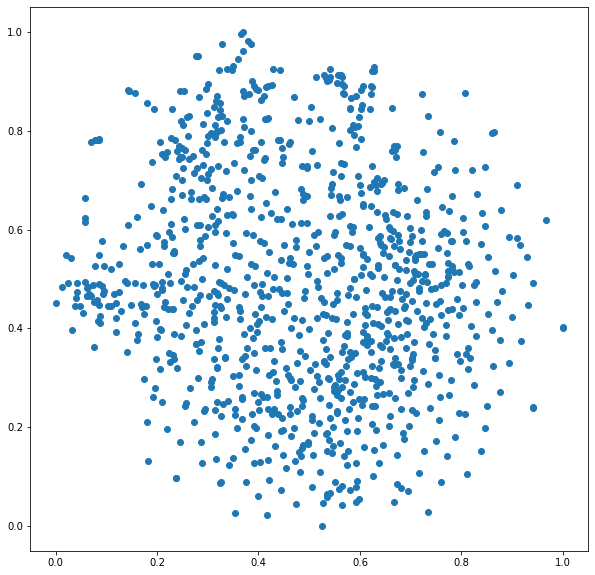

In [38]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)

ax.scatter(df_v.x, df_v.y)
plt.show()

In [39]:
df_v[df_v.x == 1]

,title,preview,article,tags,link,tsne_x,tsne_y,x,y,dbscan2
437,Доброшрифт: так пишутся добрые дела,"Принято говорить, что такого-то числа отмечает...","Принято говорить, что такого-то числа отмечает...","[Блог компании Хабр, Accessibility *, Дизайн...",https://habr.com/ru/company/habr/blog/522330/,10.540872,-1.755035,1.0,0.401056,-1


In [40]:
from sklearn.cluster import DBSCAN

In [41]:
clustering = DBSCAN(eps=0.01, min_samples=3).fit(df_v[['x', 'y']].values)

In [42]:
from collections import Counter
from operator import itemgetter

In [43]:
counter = Counter(clustering.labels_)
for cl, cnt in sorted(counter.items(), key=itemgetter(1), reverse=True):
    print(f'{cl}\t{cnt}')

-1	825
40	8
0	7
17	7
2	6
5	6
10	6
29	5
6	4
15	4
18	4
21	4
22	4
23	4
27	4
1	3
3	3
4	3
32	3
7	3
8	3
9	3
11	3
12	3
13	3
14	3
44	3
16	3
45	3
19	3
34	3
20	3
39	3
36	3
24	3
25	3
43	3
26	3
28	3
31	3
30	3
33	3
37	3
35	3
38	3
42	3
47	3
41	3
46	3


In [44]:
df_v['dbscan2'] = clustering.labels_

In [45]:
clusters = df_v.dbscan2.unique()
n_clusters = len(clusters)

In [46]:
colors = sns.color_palette('husl', n_clusters)

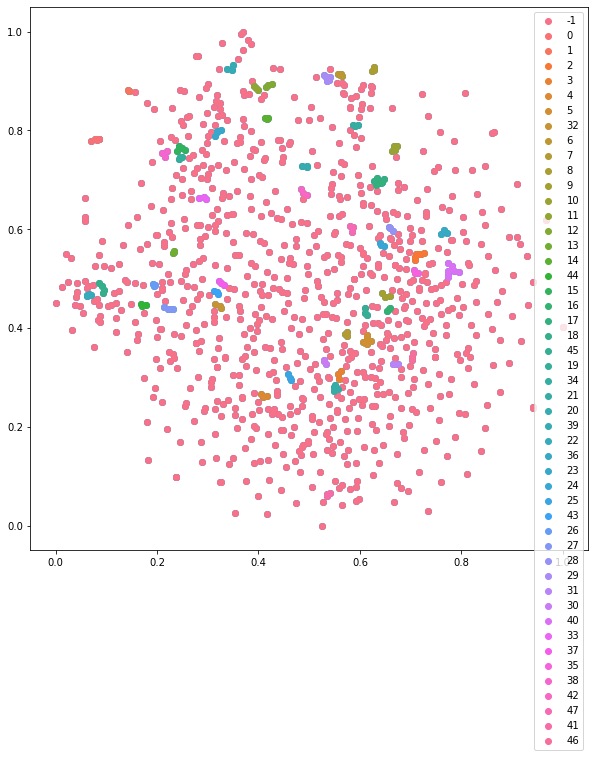

In [47]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)

ax.scatter(df_v.x, df_v.y)

for i, cl in enumerate(clusters):
    idx = df_v[df_v['dbscan2'] == cl].index
    ax.scatter(df_v.loc[idx, 'x'], df_v.loc[idx, 'y'], color=colors[i], label=f'{cl}')

ax.legend()
plt.show()